# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import random
import json
import torch
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline
from buffer import ReplayBuffer
from maddpg import MADDPG
from utilities import transpose_list, transpose_to_tensor

import warnings
warnings.filterwarnings('ignore')

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="Tennis_Windows_x86_64/Tennis.exe", no_graphics=True, seed=0)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print(states.shape)
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
(2, 24)
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [ ]:
scores_all = []
for i in range(1, 101):                                    # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent). actions.shape = (2, 2)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent). next_states.shape = (2, 24)
        rewards = env_info.rewards                         # get reward (for each agent). len(rewards) = 2
        dones = env_info.local_done                        # see if episode finished. len(dones) = 2
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    scores_all.append(np.max(scores))
print('Score (max over agents) from {} episodes : {}'.format(i, np.mean(np.array(scores_all))))
env.close() # When finished, you can close the environment.

### 4. Train the agents

In [5]:
def seeding(seed=0):
    np.random.seed(seed)
    torch.manual_seed(seed)

In [6]:
def maddpg(n_episodes=20000, max_t=200, num_agents=2, batchsize = 256, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    seeding(0)
    parallel_envs = 1
    update_count = 10
    buffer = ReplayBuffer(int(1e6)) # initialize a replay buffer
    maddpg = MADDPG() # initialize actors and critics
    
    scores_all = []                       # list containing scores from each episode
    scores_window = deque(maxlen=100)     # last 100 scores
    eps = eps_start                       # initialize epsilon
    max_mean = -np.inf
    i_episode_solved = 0
    first_solve = True
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        states = env_info.vector_observations # get the current state (for each agent)
        states_exp = np.expand_dims(states, axis = 0) # (1, 2, 24)
        scores_episode = np.zeros(num_agents) # initialize the score (for each agent)
        for t in range(max_t):
            # select an action (for each agent)
            actions = maddpg.act(transpose_to_tensor(states_exp), noise=eps) # transpose_to_tensor(states_exp)[0] -> torch.Size([1, 24])
            actions_array = torch.stack(actions).detach().numpy() # (2, 1, 2)
            actions_for_env = np.rollaxis(actions_array,1) # (1, 2, 2) 
            
            # send all actions to tne environment
            env_info = env.step(actions_for_env[0])[brain_name]
            
            next_states = env_info.vector_observations   # get next state (for each agent)
            next_states_exp = np.expand_dims(next_states, axis = 0) # (1, 2, 24)
            next_states_exp_full = np.reshape(next_states_exp, (1, num_agents*next_states_exp.shape[2])) # (1, 48)
            states_exp_full = np.reshape(states_exp, (1, num_agents*states_exp.shape[2])) # (1, 48)
            rewards = env_info.rewards                   # get reward (for each agent)
            dones = env_info.local_done                  # see if episode has finished (for any agent)
            rewards_exp = np.expand_dims(np.array(rewards), axis = 0) # (1, 2)
            dones_exp = np.expand_dims(np.array(dones), axis = 0) # (1, 2)
            
            # add data to buffer
            transition = (states_exp, states_exp_full, actions_for_env, rewards_exp, next_states_exp, next_states_exp_full, dones_exp)
            buffer.push(transition)
            
            states_exp = next_states_exp                 # roll over states to next time step
            scores_episode += rewards                    # update the score (for each agent)
            if np.any(dones):                            # exit loop if episode finished
                break
        
        # update the actor and critic networks for all agents
        if len(buffer) > batchsize:
            for i in range(update_count):
                for a_i in range(num_agents):
                    samples = buffer.sample(batchsize)
                    maddpg.update(samples, a_i)
                maddpg.update_targets()                  #soft update the target network towards the actual networks
        
        scores_window.append(np.max(scores_episode))
        scores_all.append(np.max(scores_episode))
        eps = max(eps_end, eps_decay*eps)                # decrease epsilon or noise
        print('\rEpisode {}\tAverage Score: {:.4f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.4f}'.format(i_episode, np.mean(scores_window)))
        
        #Store the weights corresponding to the best mean score
        curr_mean = np.mean(scores_window)
        if ((curr_mean >= 0.5) and (curr_mean > max_mean)):
            max_mean = curr_mean
            if (first_solve == True):
                first_solve = False
                i_episode_solved = i_episode
            #Save the best checkpoints
            torch.save(maddpg.maddpg_agent[0].actor.state_dict(), 'checkpoints/checkpoint_actor0_maddpg.pth')
            torch.save(maddpg.maddpg_agent[0].critic.state_dict(), 'checkpoints/checkpoint_critic0_maddpg.pth')
            torch.save(maddpg.maddpg_agent[1].actor.state_dict(), 'checkpoints/checkpoint_actor1_maddpg.pth')
            torch.save(maddpg.maddpg_agent[1].critic.state_dict(), 'checkpoints/checkpoint_critic1_maddpg.pth')
            #break
    print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.4f}'.format(i_episode_solved - 100, max_mean))
    return scores_all

scores = maddpg()    
env.close()

# save the scores
with open("scores_json/maddpg_scores", "w") as fp:
    json.dump(scores, fp)

Episode 100	Average Score: 0.0040
Episode 200	Average Score: 0.0070
Episode 300	Average Score: 0.0000
Episode 400	Average Score: 0.0020
Episode 500	Average Score: 0.0020
Episode 600	Average Score: 0.0145
Episode 700	Average Score: 0.0170
Episode 800	Average Score: 0.0040
Episode 900	Average Score: 0.0000
Episode 1000	Average Score: 0.0000
Episode 1100	Average Score: 0.0000
Episode 1200	Average Score: 0.0100
Episode 1300	Average Score: 0.0289
Episode 1400	Average Score: 0.0359
Episode 1500	Average Score: 0.0497
Episode 1600	Average Score: 0.0318
Episode 1700	Average Score: 0.0471
Episode 1800	Average Score: 0.0338
Episode 1900	Average Score: 0.0259
Episode 2000	Average Score: 0.0386
Episode 2100	Average Score: 0.0417
Episode 2200	Average Score: 0.0540
Episode 2300	Average Score: 0.0460
Episode 2400	Average Score: 0.0420
Episode 2500	Average Score: 0.0700
Episode 2600	Average Score: 0.0663
Episode 2700	Average Score: 0.0603
Episode 2800	Average Score: 0.0539
Episode 2900	Average Score: 0

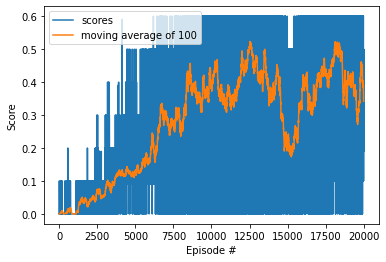

In [7]:
# Load the scores from json if needed
#with open("scores_json/maddpg_scores", "r") as fp:
#    scores = json.load(fp)

# Plot the scores
i = 0
window_size = 100
# Initialize an empty list to store moving averages
moving_averages = []

zeroes_list = [0] * (window_size-1)
new_scores = zeroes_list + scores

# Loop through the array t o
#consider every window of size 3
while i < len(new_scores) - window_size + 1:
  
    # Calculate the average of current window
    window_average = round(np.sum(new_scores[
      i:i+window_size]) / window_size, 4)
      
    # Store the average of current
    # window in moving average list
    moving_averages.append(window_average)
      
    # Shift window to right by one position
    i += 1

fig = plt.figure()
ax = fig.add_subplot(111)
x_axis_values = np.arange(len(scores))
plt.plot(x_axis_values, scores, label='scores')
plt.plot(x_axis_values, moving_averages, label='moving average of 100')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend()
plt.show()
fig.savefig("plots/training_plot_maddpg.pdf", dpi=fig.dpi)
fig.savefig("plots/training_plot_maddpg.jpg", dpi=fig.dpi)

### 5.  Test the model

In [2]:
# Load the environment
env = UnityEnvironment(file_name="Tennis_Windows_x86_64/Tennis.exe")

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [3]:
env_info = env.reset(train_mode=False)[brain_name] # reset the environment for Test
num_agents = len(env_info.agents)

# load the weights from file
maddpg = MADDPG() # initialize actors and critics
maddpg.maddpg_agent[0].actor.load_state_dict(torch.load('checkpoints/checkpoint_actor0_maddpg.pth'))
maddpg.maddpg_agent[0].critic.load_state_dict(torch.load('checkpoints/checkpoint_critic0_maddpg.pth'))
maddpg.maddpg_agent[1].actor.load_state_dict(torch.load('checkpoints/checkpoint_actor1_maddpg.pth'))
maddpg.maddpg_agent[1].critic.load_state_dict(torch.load('checkpoints/checkpoint_critic1_maddpg.pth'))

states = env_info.vector_observations # get the current state (for each agent)
states_exp = np.expand_dims(states, axis = 0)
scores_episode = np.zeros(num_agents) # initialize the score (for each agent)

for t in range(40000):
    actions = maddpg.act(transpose_to_tensor(states_exp), noise=0) # select an action (for each agent)
    actions_array = torch.stack(actions).detach().numpy()
    actions_for_env = np.rollaxis(actions_array,1)
    env_info = env.step(actions_for_env[0])[brain_name]            # send all actions to tne environment
    next_states = env_info.vector_observations                     # get next state (for each agent)
    next_states_exp = np.expand_dims(next_states, axis = 0)
    rewards = env_info.rewards                                     # get reward (for each agent)
    dones = env_info.local_done                                    # see if episode has finished (for any agent)
    states_exp = next_states_exp                                   # roll over states to next time step
    scores_episode += rewards                                      # update the score (for each agent)
    if np.any(dones):                                              # exit loop if episode finished
        break

print('Total score (max of {} agents) in Test: {}'.format(num_agents, np.max(scores_episode)))
print('Total score for agent 0 in Test: {}'.format(scores_episode[0]))
print('Total score for agent 1 in Test: {}'.format(scores_episode[1]))
env.close()

Total score (max of 2 agents) in Test: 2.600000038743019
Total score for agent 0 in Test: 2.600000038743019
Total score for agent 1 in Test: 2.600000038743019
